In [7]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator

In [12]:
import re

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [9]:
data_path = "/Users/jahrios/Documents/Stanford/PoldrackLab/Projects/SharedControl/Data/raw/"
exp_stage = "final"
task = "shared_control"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')

data_files = glob.glob(pattern)

In [10]:
def string_to_numbers(string_data):
    if isinstance(string_data, float):  # Check if the input is already a float
        return [string_data]  # If it's a float, return it as a list
    string_data = string_data.strip("'")  # Remove leading and trailing single quotes
    numbers = [float(num) for num in string_data.split()]
    return numbers

In [166]:
def process_trial_data(data, min_delay=0.175, threshold_reduction=0.30):
    trial_results = {}
    ssrt_list = []

    for idx, row in data.iterrows():
        trial_number = idx
        stop_onset = row['SSD_mean']
        time_stamps = row['time_stamps_raw']
        pressures_raw = row['pressures_raw']

        # Calculate the minimum time to start checking for inhibition
        start_check_time = stop_onset + min_delay

        # Find the index where to start checking (first index after the start_check_time)
        index_of_start_check = next((i for i, t in enumerate(time_stamps) if t >= start_check_time), None)

        index_of_inhibition = None
        stop_moment = None
        moment_of_inhibition = None

        # Find the start of inhibition (first point where pressure reduces by at least 30% monotonically)
        if index_of_start_check is not None:
            for i in range(index_of_start_check, len(pressures_raw) - 1):
                current_pressure = pressures_raw[i]
                target_pressure = current_pressure * (1 - threshold_reduction)
                # Check if the pressure decreases to below the target and stays below it for a sequence
                if pressures_raw[i] > target_pressure:
                    if all(pressures_raw[j] <= pressures_raw[i] for j in range(i+1, min(i+5, len(pressures_raw)))):
                        if any(pressures_raw[j] <= target_pressure for j in range(i+1, min(i+5, len(pressures_raw)))):
                            moment_of_inhibition = time_stamps[i]
                            index_of_inhibition = i
                            break

        # Find the end of inhibition (first zero pressure after the start of inhibition)
        if index_of_inhibition is not None:
            stop_moment_indices = [i for i in range(index_of_inhibition, len(pressures_raw)) if pressures_raw[i] == 0]
            if stop_moment_indices:
                stop_moment = time_stamps[stop_moment_indices[0]]

        # Store the results in the dictionary
        trial_results[trial_number] = {
            'stop_onset': stop_onset,
            'stop_moment': stop_moment,
            'moment_of_inhibition': moment_of_inhibition,
            'index_of_inhibition': index_of_inhibition,
            'distances_raw': row['distances_raw'],
            'pressures_raw': pressures_raw,
            'time_stamps_raw': time_stamps,
            'condition': row['condition'],
            'post_buffer_stamp': start_check_time
        }

        # Calculate SSRT if both inhibition start and stop moments are identified
        if stop_onset is not None and moment_of_inhibition is not None:
            ssrt = moment_of_inhibition - stop_onset
            ssrt_list.append(ssrt)
        else:
            print(f'Trial {idx} has no SSRT')
            ssrt_list.append(np.nan)

    return trial_results, ssrt_list


In [167]:
pattern = re.compile(r'sub-(s\d{3})')

In [168]:
subject_ids = [pattern.search(path).group(1) for path in data_files if pattern.search(path)]

In [204]:
df = pd.read_csv(data_files[1])
df['phase_raw'] = df['phase_raw'].str.strip("'")
df['block_raw'] = df['block_raw'].str.strip("'")

df_test = df.query("phase_raw == 'test'")
block_1 = df_test.query("block_raw == 'block 1'")
block_2 = df_test.query("block_raw == 'block 2'")
block_1 = block_1.reset_index(drop=True)
block_2 = block_2.reset_index(drop=True)

task_dfs = [block_1, block_2]

for df in task_dfs:
    if 'ai' in df['condition'].values:
        ai_data = df.copy()
        ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
        ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
        ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
    else:
        control_data = df.copy()
        control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
        control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
        control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)

data = {'ai': {'data': ai_data}, 'non_ai': {'data': control_data}}

In [205]:
trial_results, ssrt_list = process_trial_data(data['ai']['data'])
data['ai']['trial_results'] = trial_results
data['ai']['ssrt_list'] = ssrt_list  

In [206]:
trial_results.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [207]:
trial_results[0].keys()

dict_keys(['stop_onset', 'stop_moment', 'moment_of_inhibition', 'index_of_inhibition', 'distances_raw', 'pressures_raw', 'time_stamps_raw', 'condition', 'post_buffer_stamp'])

In [208]:
trial_results[12]['stop_onset']

2.116210699081421

In [209]:
trial_results[12]['moment_of_inhibition']

2.3026250042021275

In [210]:
(trial_results[12]['stop_moment'])

2.386154927313328

### Displaying Trials for QC

In [211]:
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator

In [212]:
def plot_trial_pressure_individual(trial_data, trial_number, ax, color):
    pressures_raw = trial_data['pressures_raw']
    time_stamps_raw = trial_data['time_stamps_raw']
    stop_onset_time = trial_data.get('stop_onset', None)
    moment_of_inhibition = trial_data.get('moment_of_inhibition', None)
    stop_moment = trial_data.get('stop_moment', None)
    post_buffer_stamp = trial_data.get('post_buffer_stamp', None)

    # Plotting all pressures
    ax.plot(time_stamps_raw, pressures_raw, label=f'Trial {trial_number}', color=color)

    # Adding vertical dotted lines at critical points if available
    if stop_onset_time is not None:
        ax.axvline(x=stop_onset_time, color='black', linestyle='dotted', linewidth=2, label='Stop Onset')
    if moment_of_inhibition is not None:
        ax.axvline(x=moment_of_inhibition, color='green', linestyle='dotted', linewidth=2, label='Moment of Inhibition')
    if stop_moment is not None:
        ax.axvline(x=stop_moment, color='red', linestyle='dotted', linewidth=2, label='Stop Moment')
    if post_buffer_stamp is not None:
        ax.axvline(x=post_buffer_stamp, color='purple', linestyle='dotted', linewidth=2, label='Post Buffer Stamp')

    # Setting axis labels, title, and grid
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Raw Pressure')
    ax.set_title(f'Trial {trial_number}')
    ax.legend()
    ax.grid(True)

    # Set fixed y-axis and x-axis limits
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlim(0, 6)  # Set x-axis limits from 0 to 6 seconds

    # Set x-axis major and minor ticks
    ax.xaxis.set_major_locator(MultipleLocator(1))  # Major ticks at every second
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))  # Minor ticks at every 100 ms

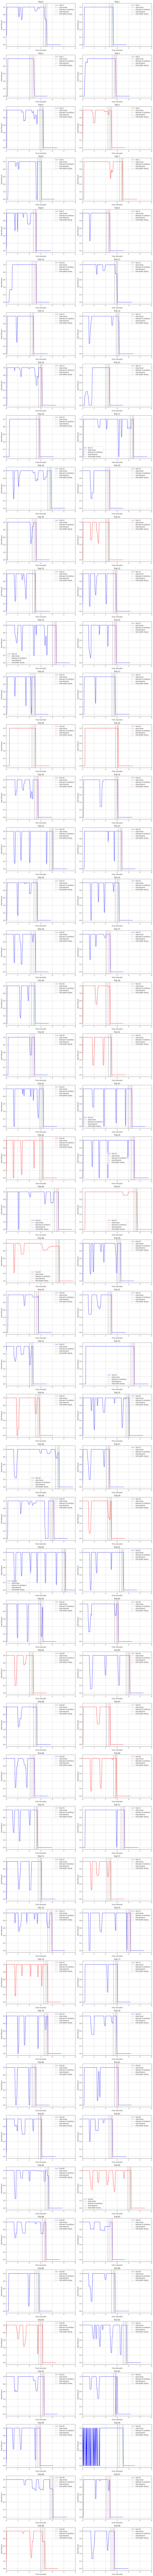

In [213]:
# plotting individual AI block trials
num_trials_ai = len(data['ai']['trial_results'])
num_cols = 2
num_rows = (num_trials_ai + 1) // 2  # Add 1 to round up

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)  # Ensure axs is always a 2D array

ai_color = 'blue'
stop_color = 'red'

for i, (trial_number, trial_data) in enumerate(data['ai']['trial_results'].items()):
    row = i // num_cols
    col = i % num_cols
    condition = trial_data['condition']
    color = ai_color if condition == 'ai' else stop_color
    plot_trial_pressure_individual(trial_data, trial_number, axs[row, col], color=color)

plt.tight_layout()
plt.show()